In [72]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [73]:
train_data = pd.read_csv('my_data.csv')
X_data_pd = train_data[['x2', 'y2']]
Y_data_pd = train_data[['q1', 'q2']]

X_data = X_data_pd.to_numpy()
Y_data = Y_data_pd.to_numpy()


In [74]:
from sklearn.model_selection import train_test_split

X_temp, X_test, Y_temp, Y_test = train_test_split(
    X_data, Y_data, test_size=0.15, random_state=42
)

X_train, X_val, Y_train, Y_val = train_test_split(
    X_temp, Y_temp, test_size=0.176, random_state=42
)

print(f"Training set size: {X_train.shape[0]}")   
print(f"Validation set size: {X_val.shape[0]}")         
print(f"Test set size: {X_test.shape[0]}")    



Training set size: 1751
Validation set size: 374
Test set size: 375


In [75]:
import tensorflow as tf

def forward_kinematics(q):
    L1 = 1.0
    L2 = 1.0
    q1 = q[:, 0]
    q2 = q[:, 1]
    x2 = L1 * tf.cos(q1) + L2 * tf.cos(q1 + q2)
    y2 = L1 * tf.sin(q1) + L2 * tf.sin(q1 + q2)
    return tf.stack([x2, y2], axis=1)

def cartesian_loss(y_true, y_pred):
    x2y2_pred = forward_kinematics(y_pred)
    return tf.reduce_mean(tf.square(y_true - x2y2_pred))

In [76]:
import tensorflow as tf
from keras.api.models import Sequential, load_model
from keras.api.layers import Dense
import os
import warnings
warnings.filterwarnings('ignore')

In [77]:
model_path = 'my_ik_model_50_50.keras'
if os.path.exists(model_path):
    model = load_model(
    model_path,
    custom_objects={'cartesian_loss': cartesian_loss}
)
else:
    model = Sequential([
        Dense(50, activation='relu', input_shape=(2,)),  # Input: x2, y2
        Dense(50, activation='relu'),
        Dense(2)  # Output: q1, q2 (linear)
    ])
    model.compile(optimizer='adam', loss=cartesian_loss)
    model.summary()

    history = model.fit(
        X_train, X_train,
        epochs=100,
        batch_size=32,
        validation_data=(X_val, X_val)
    )
    model.save(model_path)

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_4 (Dense)                 │ (None, 50)             │           150 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 50)             │         2,550 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 2)              │           102 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,802 (10.95 KB)

 Trainable params: 2,802 (10.95 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/100
55/55 ━━━━━━━━━━━━━━━━━━━━ 3s 13ms/step - loss: 0.5959 - val_loss: 0.0175
Epoch 2/100
55/55 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0158 - val_loss: 0.0092
Epoch 3/100
55/55 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0086 - val_loss: 0.0082
Epoch 4/100
55/55 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0077 - val_loss: 0.0074
Epoch 5/100
55/55 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 0.0071 - val_loss: 0.0069
Epoch 6/100
55/55 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 0.0066 - val_loss: 0.0069
Epoch 7/100
55/55 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 0.0065 - val_loss: 0.0068
Epoch 8/100
55/55 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 0.0065 - val_loss: 0.0064
Epoch 9/100
55/55 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 0.0061 - val_loss: 0.0064
Epoch 10/100
55/55 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0063 - val_loss: 0.0064
Epoch 11/100
55/55 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0059 - val_loss: 0.0062
Epoch 12/100
55/55 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - los

In [78]:
Y_pred = model.predict(X_test)

L1 = 1.0
L2 = 1.0

q1_pred = Y_pred[:,0]
q2_pred = Y_pred[:,1]

x2_pred = L1 * np.cos(q1_pred) + L2 * np.cos(q1_pred + q2_pred)
y2_pred = L1 * np.sin(q1_pred) + L2 * np.sin(q1_pred + q2_pred)
X_pred = np.stack([x2_pred, y2_pred], axis=1)

x2_true = X_test[:,0]
y2_true = X_test[:,1]


12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Mean Cartesian error: 0.020542137199957594


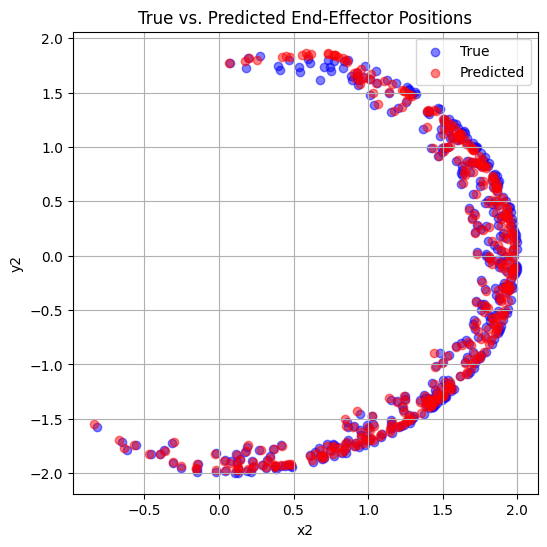

In [79]:
errors = np.sqrt((x2_true - x2_pred)**2 + (y2_true - y2_pred)**2)
print(f"Mean Cartesian error: {np.mean(errors)}")


plt.figure(figsize=(6,6))
plt.scatter(x2_true, y2_true, color='blue', alpha=0.5, label='True')
plt.scatter(x2_pred, y2_pred, color='red', alpha=0.5, label='Predicted')
plt.legend()
plt.xlabel('x2')
plt.ylabel('y2')
plt.title('True vs. Predicted End-Effector Positions')
plt.grid()
plt.show()

In [80]:
for i in range(6):
    print(f"Sample {i+1}:")
    print(f"  True joint angles (q1, q2):      {Y_test[i]}")
    print(f"  Predicted joint angles (q1, q2): {Y_pred[i]}")
    print(f"  True Cartesian (x2, y2):         {X_test[i]}")
    print(f"  Predicted Cartesian (x2, y2):    {X_pred[i]}")
    print()

Sample 1:
  True joint angles (q1, q2):      [0.94034066 0.14959965]
  Predicted joint angles (q1, q2): [ 1.2349998  -0.42568797]
  True Cartesian (x2, y2):         [1.05205118 1.69435828]
  Predicted Cartesian (x2, y2):    [1.0195181 1.6679606]

Sample 2:
  True joint angles (q1, q2):      [-0.82279808 -0.10685689]
  Predicted joint angles (q1, q2): [-0.7515261  -0.26492625]
  True Cartesian (x2, y2):         [ 1.27828327 -1.53446549]
  Predicted Cartesian (x2, y2):    [ 1.2570333 -1.5330006]

Sample 3:
  True joint angles (q1, q2):      [-0.82279808 -0.14959965]
  Predicted joint angles (q1, q2): [-0.76625633 -0.27725625]
  True Cartesian (x2, y2):         [ 1.2434928  -1.55929065]
  Predicted Cartesian (x2, y2):    [ 1.2236996 -1.5576198]

Sample 4:
  True joint angles (q1, q2):      [0.40605619 0.87622652]
  Predicted joint angles (q1, q2): [ 1.2501913 -0.8198099]
  True Cartesian (x2, y2):         [1.20321331 1.35365714]
  Predicted Cartesian (x2, y2):    [1.2239475 1.3662624]

Sa

In [81]:
def plot_robot(q1, q2, color='red', label='Predicted'):
    L1 = 1.0
    L2 = 1.0

    # Compute elbow position
    x1 = L1 * np.cos(q1)
    y1 = L1 * np.sin(q1)

    # Compute end-effector position
    x2 = x1 + L2 * np.cos(q1 + q2)
    y2 = y1 + L2 * np.sin(q1 + q2)

    # Plot the links
    plt.plot([0, x1, x2], [0, y1, y2], color=color, marker='o', label=label)
    plt.axis('equal')

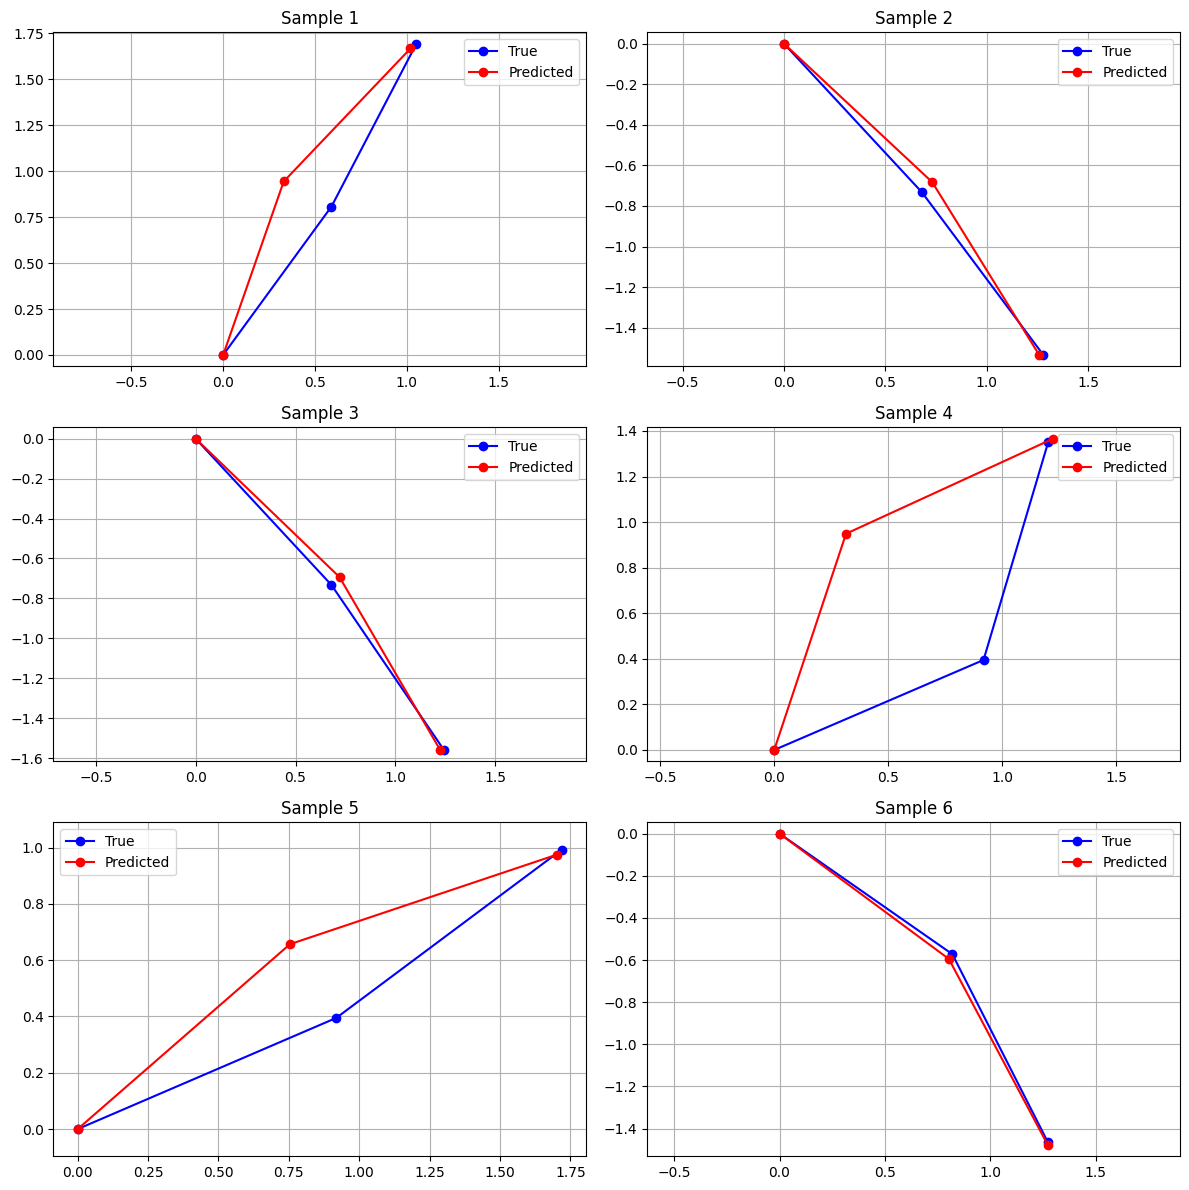

In [82]:
num_samples = 6
plt.figure(figsize=(12, 12))

for i in range(num_samples):
    plt.subplot(3, 2, i+1)
    plot_robot(Y_test[i, 0], Y_test[i, 1], color='blue', label='True')
    plot_robot(q1_pred[i], q2_pred[i], color='red', label='Predicted')
    plt.title(f'Sample {i+1}')
    plt.legend()
    plt.axis('equal')
    plt.grid(True)

plt.tight_layout()
plt.show()